In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('DATASET/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

DATASET/calendar.csv
DATASET/sales_train_evaluation.csv
DATASET/sales_train_validation.csv
DATASET/sample_submission.csv
DATASET/sell_prices.csv


In [2]:
sell_prices = pd.read_csv('DATASET/sell_prices.csv')
sample_submission = pd.read_csv('DATASET/sample_submission.csv')
calendar = pd.read_csv('DATASET/calendar.csv')
sales_train_validation = pd.read_csv('DATASET/sales_train_validation.csv')


# In this notebook, we use an ARIMA model to establish a baseline for forecasting Walmart sales. 
# First, we do some pre-processing and exploration of the data.

In [3]:
#Aggregate by the store level for now
store_level = sales_train_validation.groupby(sales_train_validation['store_id']).sum()
store_level['d'] = store_level.index
store_levelt = store_level.transpose() 
store_levelt['d'] = store_levelt.index
store_levelt

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,d
d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,d_1
d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,d_2
d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,d_3
d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,d_4
d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,d_5
...,...,...,...,...,...,...,...,...,...,...,...
d_1910,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226,d_1910
d_1911,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828,d_1911
d_1912,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686,d_1912
d_1913,6113,6082,7721,3271,4033,4292,3957,4874,5127,4325,d_1913


In [4]:
#Merge this with the calendar data set to look at trends
store_level_final = store_levelt.merge(calendar, on='d')
from datetime import datetime
store_level_final['date'] = store_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
store_level_final

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,3722,3691,5235,2500,2901,3384,3315,3242,4194,3159,...,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226,...,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828,...,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686,...,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


There are clear seasonal trends, particularly within the week. Saturday and Sunday see much higher volumes.

(array([734169., 734176., 734183., 734190., 734197., 734204., 734211.]),
 <a list of 7 Text xticklabel objects>)

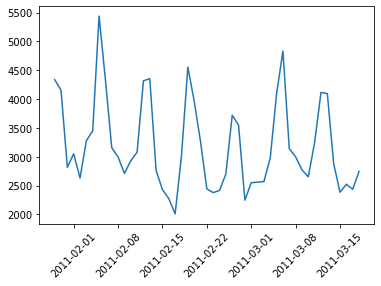

In [5]:
plt.plot(store_level_final['date'][0:49], store_level_final['CA_1'][0:49])
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

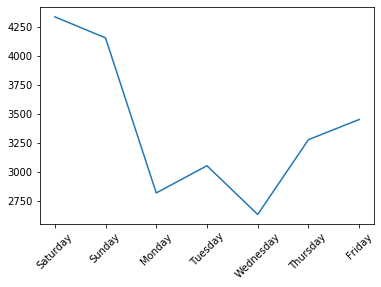

In [6]:
plt.plot(store_level_final['weekday'][0:7], store_level_final['CA_1'][0:7])
plt.xticks(rotation=45)

# Second, we look at the time series through a time series perspective, with an eye towards choosing the right ARIMA model.

We check whether this series is stationary.

In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries[0:100], color='blue',label='Original')
    mean = plt.plot(rolmean[0:100], color='red', label='Rolling Mean')
    std = plt.plot(rolstd[0:100], color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

We reject the null hypothesis that the time series has a unit root. What this means is that the time series is non-stationary.

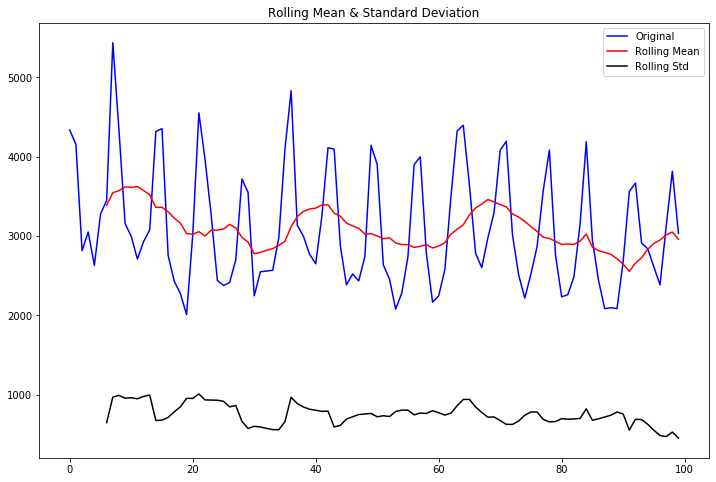

Results of Dickey-Fuller Test:
Test Statistic                 -2.461764
p-value                         0.125057
#Lags Used                     12.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [8]:
test_stationarity(store_level_final['CA_1'][0:100])

We take a look at differencing the time series.

Much better! We do not reject the null hypothesis. This is a good candidate to work with the ARIMA model.

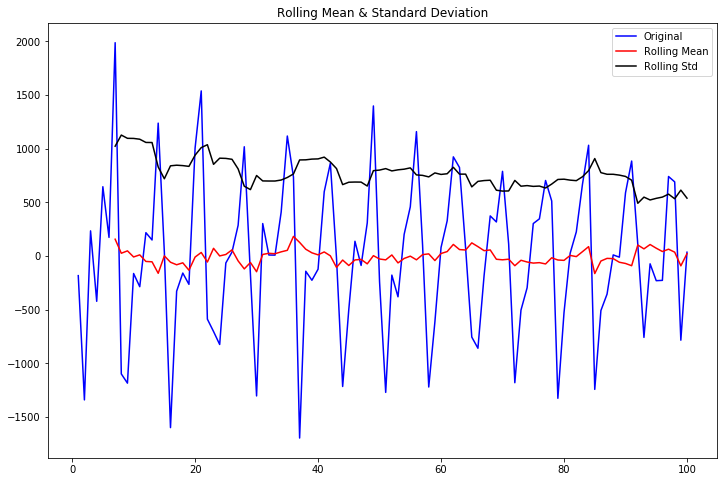

Results of Dickey-Fuller Test:
Test Statistic                  -20.626012
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    1885.000000
Critical Value (1%)              -3.433824
Critical Value (5%)              -2.863075
Critical Value (10%)             -2.567587
dtype: float64


In [9]:

store_level_final['first_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(1)
test_stationarity(store_level_final['first_difference'].dropna())

From previous analysis, it is clear that people shop more on the weekend. What if we difference to account for the weekly seasonality?

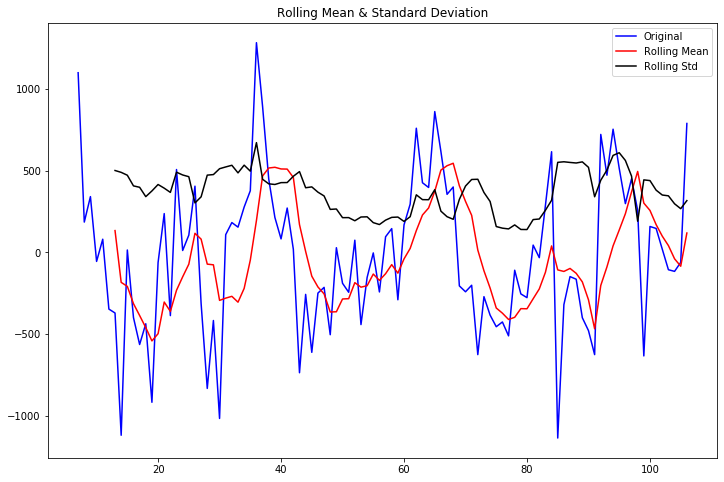

Results of Dickey-Fuller Test:
Test Statistic                  -19.400488
p-value                           0.000000
#Lags Used                       23.000000
Number of Observations Used    1882.000000
Critical Value (1%)              -3.433829
Critical Value (5%)              -2.863077
Critical Value (10%)             -2.567588
dtype: float64


In [10]:
store_level_final['seasonal_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(7)
test_stationarity(store_level_final['seasonal_difference'].dropna())

We also fail to reject the null hypothesis here. Let's combine the two.


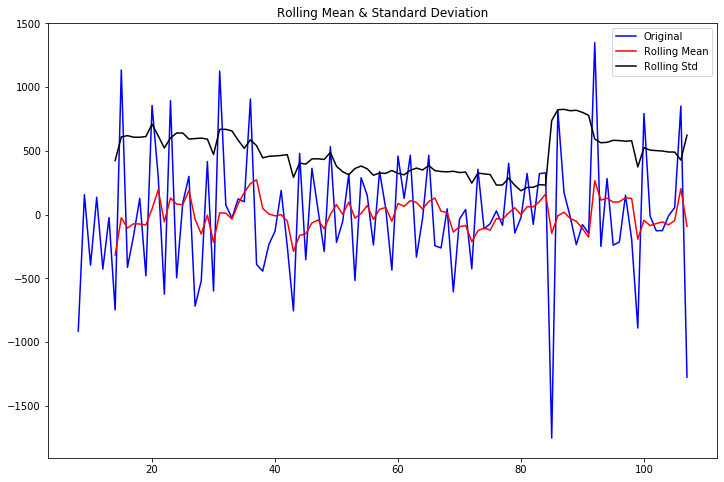

Results of Dickey-Fuller Test:
Test Statistic                  -19.739548
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    1879.000000
Critical Value (1%)              -3.433835
Critical Value (5%)              -2.863079
Critical Value (10%)             -2.567590
dtype: float64


In [11]:
store_level_final['seasonal_first_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(1) - store_level_final['CA_1'].shift(7) + store_level_final['CA_1'].shift(8)
test_stationarity(store_level_final['seasonal_first_difference'].dropna())


At this point, I think we will use the third time series because it makes the most sense. But let us set the parameters, which will give further insight.

In [12]:
from pandas.plotting import autocorrelation_plot

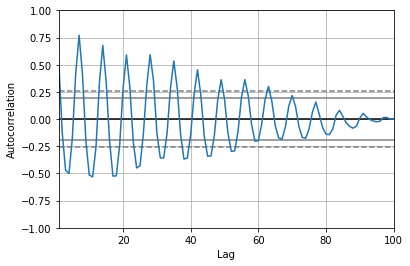

In [13]:
autocorrelation_plot(store_level_final['CA_1'][0:100])


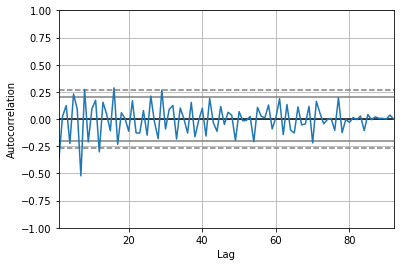

In [14]:
autocorrelation_plot(store_level_final['seasonal_first_difference'][8:100])


In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


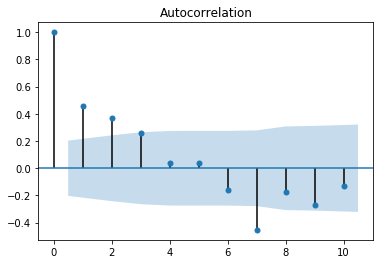

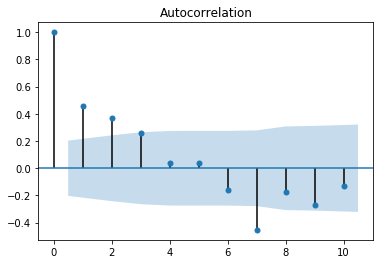

In [16]:
plot_acf(store_level_final['seasonal_difference'][0:100].dropna(), lags=10)


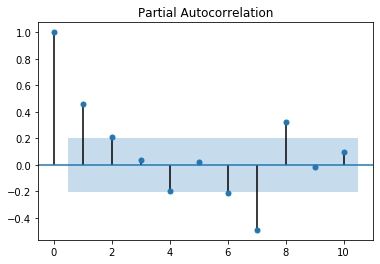

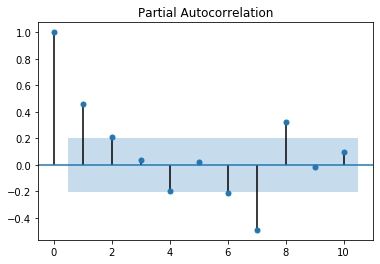

In [17]:
plot_pacf(store_level_final['seasonal_difference'][0:100].dropna(), lags=10)


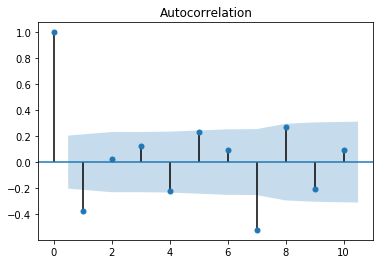

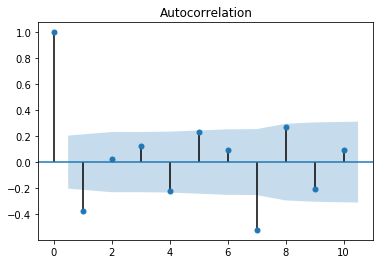

In [18]:
plot_acf(store_level_final['seasonal_first_difference'][0:100].dropna(), lags=10)


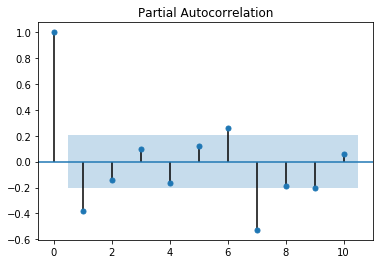

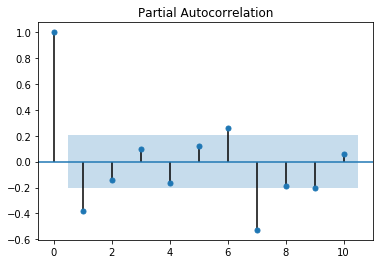

In [19]:
plot_pacf(store_level_final['seasonal_first_difference'][0:100].dropna(), lags=10)


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(store_level_final['CA_1'])

Based on the spikes at 1 for all the graphs above, as well as the spike at 7, we use a ARIMA model of (0, 1, 1)(0, 1, 1)7.

# Now we implement the model!

[](http://)

In [21]:
train = np.asarray(store_level_final['CA_1'][0:1880].astype(float))
test = np.asarray(store_level_final['CA_1'][1880:-1].astype(float))

In [22]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(train, order=(0,1,1), seasonal_order=(0,1,1,7))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1880
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood              -14119.716
Date:                           Wed, 11 Nov 2020   AIC                          28245.432
Time:                                   22:54:38   BIC                          28262.036
Sample:                                        0   HQIC                         28251.549
                                          - 1880                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7560      0.012    -63.658      0.000      -0.779      -0.733
ma.S.L7       -0.9588      0.008   -124.949

The fit is pretty good...

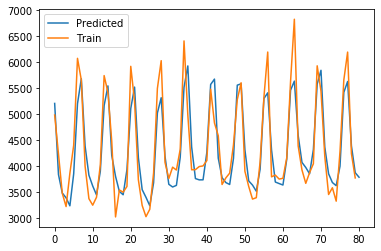

In [23]:
plt.plot(results.predict(start = 1800, end = 1880), label = 'Predicted')
plt.plot(train[1800:1880], label = 'Train')
plt.legend(loc = "upper left")

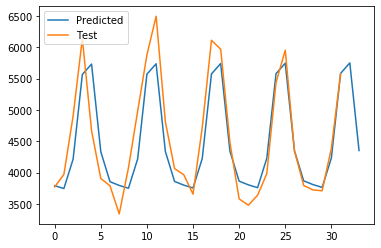

In [24]:
plt.plot(results.predict(start = len(train), end = len(store_level_final['CA_1'])), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [25]:
from sklearn.metrics import mean_squared_error
import math
mean_squared_error(results.predict(start = 1880, end = 1911), test)

156879.24147509257

In [26]:
train2 = np.asarray(store_level_final['CA_1'][1500:1880].astype(float))
test2 = np.asarray(store_level_final['CA_1'][1880:-1].astype(float))

In [27]:
import statsmodels.api as sm

mod2 = sm.tsa.statespace.SARIMAX(train2, order=(0,1,1), seasonal_order=(0,1,1,7))
results2=mod2.fit()
print(results2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  380
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -2831.597
Date:                           Wed, 11 Nov 2020   AIC                           5669.195
Time:                                   22:54:39   BIC                           5680.951
Sample:                                        0   HQIC                          5673.864
                                           - 380                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8420      0.024    -34.935      0.000      -0.889      -0.795
ma.S.L7       -0.9014      0.025    -35.493

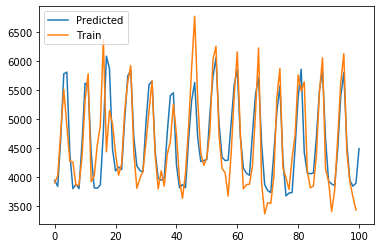

In [28]:
plt.plot(results2.predict(start = 100, end = 200), label = 'Predicted')
plt.plot(train2[100:200], label = 'Train')
plt.legend(loc = "upper left")

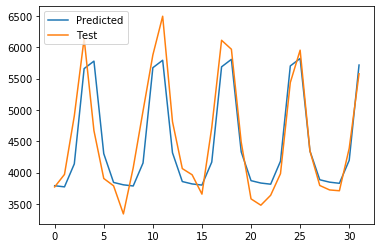

In [29]:
plt.plot(results2.predict(start = 380, end = 411), label = 'Predicted')
plt.plot(test2, label = 'Test')
plt.legend(loc = "upper left")

In [30]:
mean_squared_error(results2.predict(start = 380, end = 411), test2)

159455.86863954485

In [31]:
store_level

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,5437,5954,4345,3793,3722,3709,4387,5577,6113,CA_1
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,5352,5760,3830,3631,3691,3303,4457,5884,6082,CA_2
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,6936,8271,6068,5683,5235,5018,5623,7419,7721,CA_3
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2839,3047,2809,2677,2500,2458,2628,2954,3271,CA_4
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3724,4192,3410,3257,2901,2776,3022,3700,4033,TX_1
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,4475,4998,3311,3727,3384,3446,3902,4483,4292,TX_2
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,4261,4519,3147,3938,3315,3380,3691,4083,3957,TX_3
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,4862,4812,3236,3069,3242,3324,3991,4772,4874,WI_1
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,5579,5566,4347,4464,4194,4393,4988,5404,5127,WI_2


In [32]:
category_sales = sales_train_validation.groupby(sales_train_validation['cat_id']).sum()
category_salest = category_sales.transpose()
category_salest['d'] = category_salest.index

In [33]:
#Merge this with the calendar data set to look at trends
category_level_final = category_salest.merge(calendar, on='d')
category_level_final['date'] = category_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
category_level_final

,FOODS,HOBBIES,HOUSEHOLD,d,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,23178,3764,5689,d_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,22758,3357,5634,d_2,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,17174,2682,3927,d_3,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,18878,2669,3865,d_4,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,14603,1814,2729,d_5,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,23632,3472,8239,d_1909,2016-04-20,11612,Wednesday,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,23317,3353,8363,d_1910,2016-04-21,11612,Thursday,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,26704,4085,9728,d_1911,2016-04-22,11612,Friday,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,31927,4787,12248,d_1912,2016-04-23,11613,Saturday,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [34]:
category_level_model = category_level_final
category_level_model['FOODS'].loc[category_level_model['event_name_1'] == 'Christmas'] = category_level_final['FOODS'].mean()
category_level_model['HOBBIES'].loc[category_level_model['event_name_1'] == 'Christmas'] = category_level_final['HOBBIES'].mean()
category_level_model['HOUSEHOLD'].loc[category_level_model['event_name_1'] == 'Christmas'] = category_level_final['HOUSEHOLD'].mean()

C:\Users\MOHITBHAT\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'Food: SARIMA Model Prediction vs. Test with RMSE = 2589')

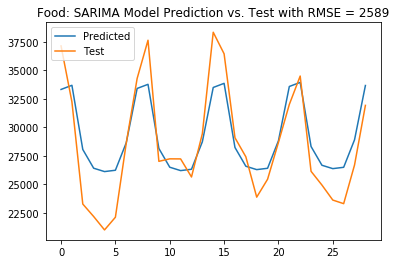

In [35]:
train_food = np.asarray(category_level_model['FOODS'][0:1883].astype(float))
test_food = np.asarray(category_level_model['FOODS'][1883:-1].astype(float))
mod_food = sm.tsa.statespace.SARIMAX(train_food, order=(0,1,1), seasonal_order=(0,1,1,7))
results_food=mod_food.fit()
plt.plot(results_food.predict(start = len(train_food), end = 1911), label = 'Predicted')
plt.plot(test_food, label = 'Test')
plt.legend(loc = 'upper left')
rmse = math.sqrt(mean_squared_error(results_food.predict(start = 1883, end = 1911), test_food))
plt.title("Food: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))


In [36]:
rmse / np.std(train_food)

0.549622032318061

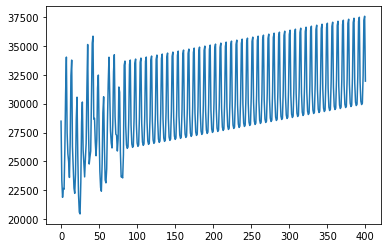

In [37]:
plt.plot(results_food.predict(start = 1800, end = 2200), label = 'Predicted')


Text(0.5, 1.0, 'Hobbies: SARIMA Model Prediction vs. Test with RMSE = 316')

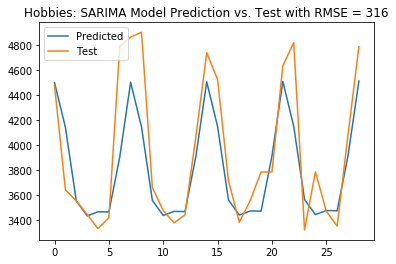

In [38]:
train_hobbies = np.asarray(category_level_model['HOBBIES'][0:1883].astype(float))
test_hobbies = np.asarray(category_level_model['HOBBIES'][1883:-1].astype(float))
mod_hobbies = sm.tsa.statespace.SARIMAX(train_hobbies, order=(0,1,1), seasonal_order=(0,1,1,7))
results_hobbies = mod_hobbies.fit() 
plt.plot(results_hobbies.predict(start = len(train_hobbies), end = 1911), label = 'Predicted')
plt.plot(test_hobbies, label = 'Test')
plt.legend(loc = 'upper left')
rmse = math.sqrt(mean_squared_error(results_hobbies.predict(start = 1883, end = 1911), test_hobbies))
plt.title("Hobbies: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))

Text(0.5, 1.0, 'Household: SARIMA Model Prediction vs. Test with RMSE = 820')

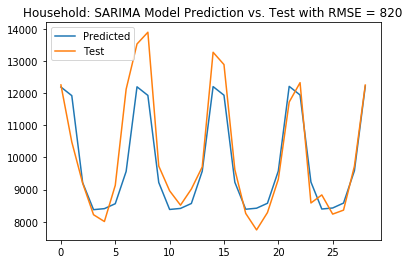

In [39]:
train_household = np.asarray(category_level_final['HOUSEHOLD'][0:1883].astype(float))
test_household = np.asarray(category_level_final['HOUSEHOLD'][1883:-1].astype(float))
mod_household = sm.tsa.statespace.SARIMAX(train_household, order=(0,1,1), seasonal_order=(0,1,1,7))
results_household = mod_household.fit()
plt.plot(results_household.predict(start = len(train_household), end = 1911), label = 'Predicted')
plt.plot(test_household, label = 'Test')
plt.legend(loc = 'upper left')
rmse = math.sqrt(mean_squared_error(results_household.predict(start = 1883, end = 1911), test_household))
plt.title("Household: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))

In [40]:
train_order = np.asarray(store_level_final['CA_1'][0:1000].astype(float))
test_order = np.asarray(store_level_final['CA_1'][1000:-1].astype(float))